# Import Packages

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import re
import datetime

# Import Data

The data for this project comes from [Kaggle](https://www.kaggle.com/datasets/debjeetdas/air-concentration-for-the-chernobyl-disaster), and contains air quality data from regions surrounding the Chernobyl nuclear plant immediately following the meltdown that took place there. 

The data is contained in the csv file `chernobyl_air_quality.csv`, and is loaded into the notebook in the cell below as a dataframe, `df`.

In [2]:
df = pd.read_csv('chernobyl_air_quality.csv')
df.head()

,PAYS,Code,Ville,X,Y,Date,End_of_sampling,Duration(h.min),I_131_(Bq/m3),Cs_134_(Bq/m3),Cs_137_(Bq/m3)
0,SE,1,RISOE,12.07,55.7,86/04/27,24:00:00,24.0,1,0,0.24
1,SE,1,RISOE,12.07,55.7,86/04/28,24:00:00,24.0,0.0046,0.00054,0.00098
2,SE,1,RISOE,12.07,55.7,86/04/29,12:00,12.0,0.0147,0.0043,0.0074
3,SE,1,RISOE,12.07,55.7,86/04/29,24:00:00,12.0,0.00061,0,0.00009
4,SE,1,RISOE,12.07,55.7,86/04/30,24:00:00,24.0,0.00075,0.0001,0.00028


Based off the first few rows of the dataset, we see that each individual row pertains to a air quality measurement taken in a certain place at a certain time. 

# Data Cleaning
## Rename Columns

The column names from the preview of the data shown above are not the most intuitive, so the cell below uses  the description of the data from Kaggle to rename them more appropriately.

In [3]:
col_names = ['country_iso', 'country_code', 'locality', 'latitude', 'longitude', 'date', 'sampling_end_time', 
             'sampling_duration', 'I131_conc', 'Cs134_conc', 'Cs137_conc']
df.columns = col_names
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country_iso        2051 non-null   object 
 1   country_code       2051 non-null   int64  
 2   locality           2051 non-null   object 
 3   latitude           2051 non-null   float64
 4   longitude          2051 non-null   float64
 5   date               2051 non-null   object 
 6   sampling_end_time  2051 non-null   object 
 7   sampling_duration  2051 non-null   float64
 8   I131_conc          2051 non-null   object 
 9   Cs134_conc         2051 non-null   object 
 10  Cs137_conc         2051 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 176.4+ KB


Thankfully, we see from the above ouput that none of the columns have null values. More specifics on the data in each of the columns above can be found in the following table: 

| Column Name | Description |
| --- | --- |
| `country_iso` | The two letter ISO country code of the location where the air quality sample was taken. |
| `country_code` | A unique numerical identifier pertaining to the country of the location where the air quality sample was taken. |
| `locality` | The municipality, city, or region region of the location where the air quality sample was taken. |
| `latitude` | The latitude of the `locality` the sample was taken from. |
| `longitude` | The longitude of the `locality` the sample was taken from. |
| `date` | The date the sample was taken. |
| `sampling_end_time` | The time of day the sample was finished being taken. |
| `sampling_duration` | The amount of time that was spent collecting the sample. |
| `I131_conc` | The concentration of the radioactive isotope I-131 in becquerels per cubic meter |
| `Cs134_conc` | The concentration of the radioactive isotope Cs-134 in becquerels per cubic meter |
| `Cs137_conc` | The concentration of the radioactive isotope Cs-136 in becquerels per cubic meter |


## Clean Country Columns

Given that we have two country columns (`country_iso` and `country_code`), it is likely that one of them can be thrown away. However, we first have to check if these columns have a 1-to-1 relationship (meaning they both provide the same exact information). This is checked in the cell below via a groupby:

In [4]:
df[['country_iso', 'country_code']].groupby(['country_iso', 'country_code']).count().reset_index()

,country_iso,country_code
0,AU,14
1,BE,10
2,CH,13
3,CZ,23
4,DE,2
5,ES,11
6,F,3
7,FI,20
8,GR,8
9,HU,24


Unfortunately, we see that there is a single `country_iso` value ("SE") that maps to two different `country_id` values. If we look at the unique localities for rows in which `country_iso == 'SE'`, we can see why:

In [5]:
set(df[df['country_iso'] == 'SE']['locality'])

{'GOETEBORG', 'LJUNGBYHED', 'OESTERSUND', 'RISOE', 'STOCKHOLM', 'UMEAA'}

Some google searching reveals that the locality, "RISOE", is actually in Denmark. As such, the code below changes the problematic "SE" rows into the ISO two-letter country code for Denmark ("DE"), and then checks again to make sure the two columns have a 1-to-1 relationship:

In [6]:
df.loc[df['locality'] == 'RISOE', 'country_iso'] = 'DE'
df[['country_iso', 'country_code']].groupby(['country_iso', 'country_code']).count().reset_index()

,country_iso,country_code
0,AU,14
1,BE,10
2,CH,13
3,CZ,23
4,DE,1
5,DE,2
6,ES,11
7,F,3
8,FI,20
9,GR,8


Since we have confirmed that these two columns now provide the same exact information, the `country_code` column is removed in the cell below. 

In [7]:
df = df.drop(columns=['country_code'])

## Clean Date Columns

The cell below accomplishes two tasks: 

1. Change the type of the `date` column from "object" to "datetime", so it can be used as such in future analysis.
2. Removes the `sampling_end_time` column, and there is no real need to knowing at what time of day the air quality measurement was finished. 

In [8]:
df['date'] = pd.to_datetime(df['date'], format="%y/%m/%d", errors='coerce')
df = df.drop(columns=['sampling_end_time'])

Next, the cell below cleans the `sampling_duration` columnn. The description of the field in Kaggle states that the values in this field are of the form "hour.minute", and because of this we see in the `.info` printout of our dataframe that that this column was actually parsed as a floating point field. As such, the "numerical" values in this field are misleading, i.e. two and a half hours would be represented as 2.30, not 2.5. The cell below fixes this by extracting the decimal part and whole number part of each value, and appropriately converting the minutes to a number between 0 and 100 as opposed to 0 and 60: 

In [9]:
df['sampling_duration'] = df['sampling_duration'].astype('str')
df['sampling_duration_mins'] = (df['sampling_duration'].str.extract(r'\d*.(\d*)').astype('float') * (10/6)) / 100
df['sampling_duration_hours'] = df['sampling_duration'].str.extract(r'(\d*).\d*').astype('float')
df['sampling_duration'] = df['sampling_duration_mins'] + df['sampling_duration_hours']
df = df.drop(columns = ['sampling_duration_mins', 'sampling_duration_hours'])

## Convert Concentration Fields to Numeric Type

The `.info` output of our dataframe also reveals that the three concentration columns were actually parsed as object fields. The reason why can be seen in the output of the cell below: there are a number of measurements in which those fields have "?", "L", or "N" characters. 

In [10]:
set(df['I131_conc'].str[-1:]).union(set(df['Cs134_conc'].str[-1:]).union(df['Cs137_conc'].str[-1:]))

{'0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'L', 'N'}

Because we do not have actual measurements for these rows, they are dropped in the cell below 

In [11]:
rows_to_drop = list(
    set(df['I131_conc'].str.extract(r'^([LN?])*$').dropna().index).union(
        set(df['Cs134_conc'].str.extract(r'^([LN?])*$').dropna().index)).union(
            set(df['Cs137_conc'].str.extract(r'^([LN?])*$').dropna().index)))
df = df.drop(rows_to_drop).reset_index(drop=True)
df.head()

,country_iso,locality,latitude,longitude,date,sampling_duration,I131_conc,Cs134_conc,Cs137_conc
0,DE,RISOE,12.07,55.7,1986-04-27,24.0,1,0,0.24
1,DE,RISOE,12.07,55.7,1986-04-28,24.0,0.0046,0.00054,0.00098
2,DE,RISOE,12.07,55.7,1986-04-29,12.0,0.0147,0.0043,0.0074
3,DE,RISOE,12.07,55.7,1986-04-29,12.0,0.00061,0,0.00009
4,DE,RISOE,12.07,55.7,1986-04-30,24.0,0.00075,0.0001,0.00028


We can now safely convert the concentration columns into numeric fields:

In [12]:
df[['I131_conc', 'Cs134_conc', 'Cs137_conc']] = df[['I131_conc', 'Cs134_conc', 'Cs137_conc']].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1415 entries, 0 to 1414
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   country_iso        1415 non-null   object        
 1   locality           1415 non-null   object        
 2   latitude           1415 non-null   float64       
 3   longitude          1415 non-null   float64       
 4   date               1415 non-null   datetime64[ns]
 5   sampling_duration  1415 non-null   float64       
 6   I131_conc          1415 non-null   float64       
 7   Cs134_conc         1415 non-null   float64       
 8   Cs137_conc         1415 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 99.6+ KB


## Add Distance Column

A column that will likely be interesting to add to this dataframe is the acutal distance each site is from the Chernobyl Nuclear reactor. Another quick Google search reveals that its location is 51°23′23″N, 30°5′58″E. To get the distance between each site and the reactor, we can use the Pythagorean theorem. While this won't be exact due to the fact that the surface of the earth is curved, it should give a relative measure of the distance between the reactor and different localities. The code in the cell below calculates this new field, `dist_to_reactor`:

In [13]:
df['dist_to_reactor'] = np.sqrt((51-df['latitude'])**2+(30-df['longitude'])**2)
df.head()

,country_iso,locality,latitude,longitude,date,sampling_duration,I131_conc,Cs134_conc,Cs137_conc,dist_to_reactor
0,DE,RISOE,12.07,55.7,1986-04-27,24.0,1.00000,0.00000,0.24000,46.647989
1,DE,RISOE,12.07,55.7,1986-04-28,24.0,0.00460,0.00054,0.00098,46.647989
2,DE,RISOE,12.07,55.7,1986-04-29,12.0,0.01470,0.00430,0.00740,46.647989
3,DE,RISOE,12.07,55.7,1986-04-29,12.0,0.00061,0.00000,0.00009,46.647989
4,DE,RISOE,12.07,55.7,1986-04-30,24.0,0.00075,0.00010,0.00028,46.647989


# Analysis

Now that the data has been cleaned, we can begin to analyze it. 

## Average Radioactivity Concentration Over Time (Plot 1)

Firstly, one can expect that over time the concentractions of radioactive isotopes in the air will begin to dissapate. This assumption is checked in the cell below, which plots the average radioactive isotope concentration from all locations over time:

In [14]:
conc_fields = ['I131_conc', 'Cs134_conc', 'Cs137_conc', 'date']
plt_data1 = df[conc_fields].groupby(['date']).mean().reset_index()
plt_data1.head()

,date,I131_conc,Cs134_conc,Cs137_conc
0,1986-04-27,1.000000,0.000000,0.240000
1,1986-04-28,2.512368,0.667041,1.255278
2,1986-04-29,1.739326,0.118871,0.631713
3,1986-04-30,4.540923,0.536836,1.199730
4,1986-05-01,6.496007,0.693154,1.724205


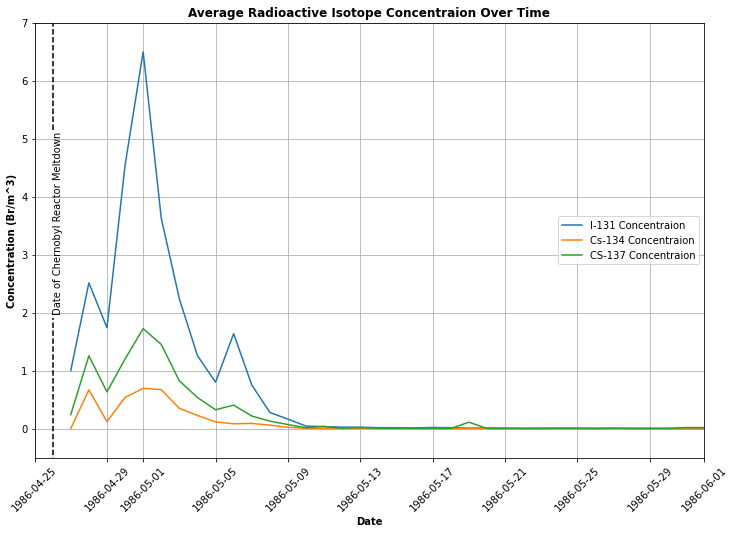

In [15]:
plt.figure(figsize=(12,8))
plt.plot(plt_data1.date, plt_data1.I131_conc, label = 'I-131 Concentraion')
plt.plot(plt_data1.date, plt_data1.Cs134_conc, label = 'Cs-134 Concentraion')
plt.plot(plt_data1.date, plt_data1.Cs137_conc, label = 'CS-137 Concentraion')
plt.xticks(rotation=45)
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Concentration (Br/m^3)', fontweight='bold')
plt.title('Average Radioactive Isotope Concentraion Over Time', fontweight='bold')
plt.xlim([datetime.date(1986, 4, 25), datetime.date(1986, 6, 1)])
plt.ylim(-0.5, 7)
plt.text(datetime.date(1986, 4, 26), 2, 'Date of Chernobyl Reactor Meltdown', rotation=90, size=10)
plt.vlines(x=datetime.date(1986, 4, 26), ymin=-1, ymax=1.9, colors='black', ls='--')
plt.vlines(x=datetime.date(1986, 4, 26), ymin=5.15, ymax=7, colors='black', ls='--')
plt.grid()
plt.legend(loc='center right')
plt.xticks
plt.show()

We see in the above image that in the days immediately following the Chernobyl disaster, the average concentration of radioactive isotopes in the air in areas surrounding the nuclear reactor increased dramatically. However, after a month and a half or so, many of the areas saw concentrations return to normal levels in the air. 

## Average Radioactivity Concentration By Distance from Reactor

Another reasonable assumption about the data is that countries or localities farther away from the nuclear reactor will have a more minimal impact on the level of radioactive isotope concentration in the air. The cell below creates a plot to check this:

In [16]:
conc_fields = ['I131_conc', 'Cs134_conc', 'Cs137_conc', 'dist_to_reactor']
plt_data2 = df[conc_fields].groupby(['dist_to_reactor']).mean().reset_index()
plt_data2.head()

,dist_to_reactor,I131_conc,Cs134_conc,Cs137_conc
0,12.796582,0.661500,0.154,0.275000
1,13.138409,0.340000,0.047,1.100000
2,15.701777,0.614000,0.128,0.200000
3,28.371260,1.444800,0.000,0.404800
4,29.982505,1.129444,0.000,0.341111


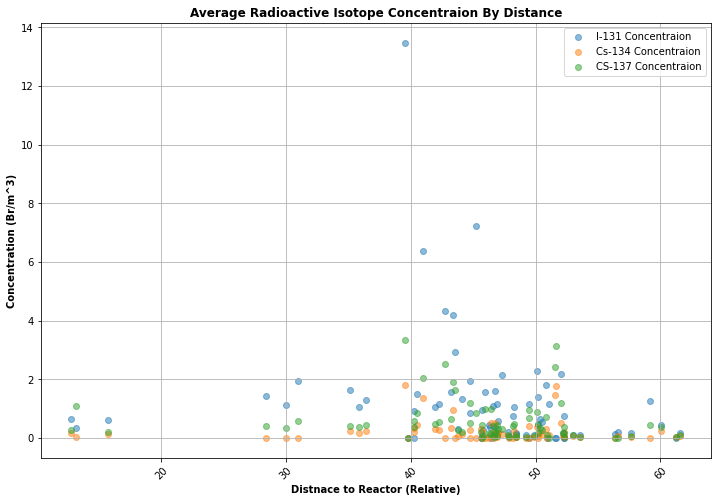

In [17]:
plt.figure(figsize=(12,8))
plt.scatter(plt_data2.dist_to_reactor, plt_data2.I131_conc, alpha=0.5, label = 'I-131 Concentraion')
plt.scatter(plt_data2.dist_to_reactor, plt_data2.Cs134_conc, alpha=0.5, label = 'Cs-134 Concentraion')
plt.scatter(plt_data2.dist_to_reactor, plt_data2.Cs137_conc, alpha=0.5, label = 'CS-137 Concentraion')
plt.xticks(rotation=45)
plt.xlabel('Distnace to Reactor (Relative)', fontweight='bold')
plt.ylabel('Concentration (Br/m^3)', fontweight='bold')
plt.title('Average Radioactive Isotope Concentraion By Distance', fontweight='bold')
plt.grid()
plt.legend()
plt.xticks
plt.show()

Surprisingly, the plot above shows that there does not appear to be any real correlation between distance from the reactor and radioactive isotope concentration. This could be do to the fact that radition doesn't really dissipate in the air, more just spreads and moves in plumes depending on a multitude of factors. It could also be due to the fact that our distance measurement was more of an estimate, and could be more precise in the way it handles longitude and latitude. Lastly, it could also be that the data doesn't include air quality measurements from countries that are outside the immediate vicinity of the reactor.

## Maximum Radition Measure By Country

The plot below determines the maximum radioactive isotope concentration measured in each country, and displays them on a bar graph. Note that in this case only a single isotope was used, Cs-134.

In [18]:
conc_fields = ['Cs134_conc', 'country_iso']
plt_data3 = df[conc_fields].groupby(['country_iso']).max().reset_index().sort_values('Cs134_conc')
plt_data3.head()

,country_iso,Cs134_conc
8,GR,0.0000
12,NO,0.0000
5,ES,0.0481
9,HU,0.8000
13,SE,0.9350


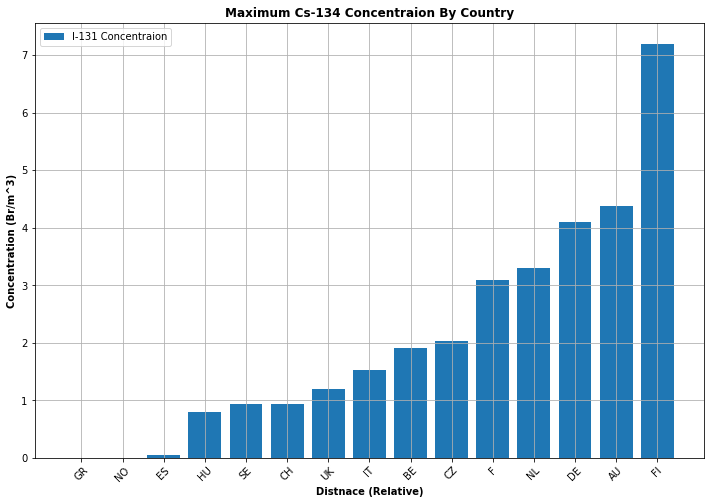

In [19]:
plt.figure(figsize=(12,8))
plt.bar(plt_data3.country_iso, plt_data3.Cs134_conc, label = 'I-131 Concentraion')
plt.xticks(rotation=45)
plt.xlabel('Distnace (Relative)', fontweight='bold')
plt.ylabel('Concentration (Br/m^3)', fontweight='bold')
plt.title('Maximum Cs-134 Concentraion By Country', fontweight='bold')
plt.grid()
plt.legend()
plt.xticks
plt.show()

Based on the bar chart, Austria and Finland were the countries to witness the highest Cs-134 concentrations. This aligns with the information presented in graphic shown below, which provides an estimate of the radition spread conducted by the United Nations Enviornmental Program. 

![alternative text](Radiation_Spread.jpeg)


# Conclusion

Based off the results of the above graphics, we can clearly see the immediate impact that the Chernobyl distaster had on the air quality of the surrounding regions: in the days following the event, radioactive isotope concentrations in the air increased dramatically. However, it is also clear from the above that distance from the reactor was not the only factor is determining how significant the radiation exposure would become, with suspected variables such as wind direction, temperature, and topology also likely being noteworthy factors.

# Recreate Graphics In Seaborn

For the purposes of this assignment, the following cells show how to recreate each of the above plots using the `seaborn` package. 

## Plot 1

In [20]:
import seaborn as sns

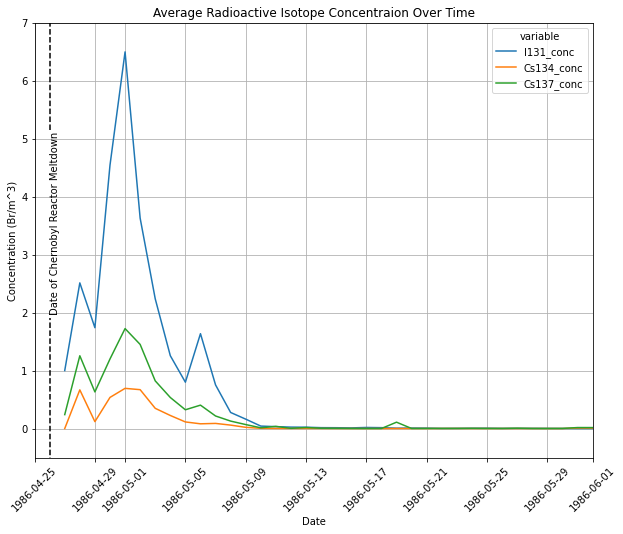

In [21]:
plt_data1_sns = pd.melt(plt_data1, id_vars='date', value_vars=['I131_conc', 'Cs134_conc', 'Cs137_conc'])

plt.figure(figsize=(10,8))
ax = sns.lineplot(data=plt_data1_sns, x="date", y="value", hue='variable')

#specfiy axis labels, xy lims
ax.set(xlabel='Date',
       ylabel='Concentration (Br/m^3)',
       title='Average Radioactive Isotope Concentraion Over Time',
       ylim=(-0.5, 7),
       xlim=([datetime.date(1986, 4, 25), datetime.date(1986, 6, 1)]))

# still have to do folllowing using matplotlib functions
plt.xticks(rotation=45)
plt.text(datetime.date(1986, 4, 26), 2, 'Date of Chernobyl Reactor Meltdown', rotation=90, size=10)
plt.vlines(x=datetime.date(1986, 4, 26), ymin=-1, ymax=1.9, colors='black', ls='--')
plt.vlines(x=datetime.date(1986, 4, 26), ymin=5.15, ymax=7, colors='black', ls='--')
plt.grid()
plt.show()

## Plot 2

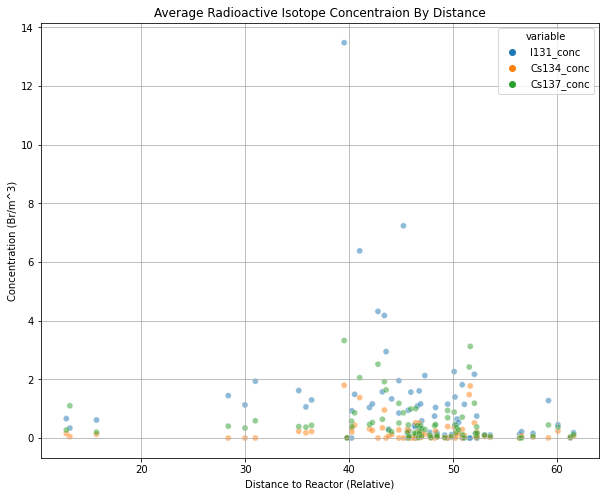

In [22]:
plt_data2_sns = pd.melt(plt_data2, id_vars='dist_to_reactor', value_vars=['I131_conc', 'Cs134_conc', 'Cs137_conc'])

plt.figure(figsize=(10,8))
ax = sns.scatterplot(data=plt_data2_sns, x="dist_to_reactor", y="value", hue='variable', alpha=0.5)

# specfiy axis labels
ax.set(xlabel='Distance to Reactor (Relative)',
       ylabel='Concentration (Br/m^3)',
       title='Average Radioactive Isotope Concentraion By Distance')

# still have to do folllowing using matplotlib functions
plt.grid()
plt.show()

## Plot 3

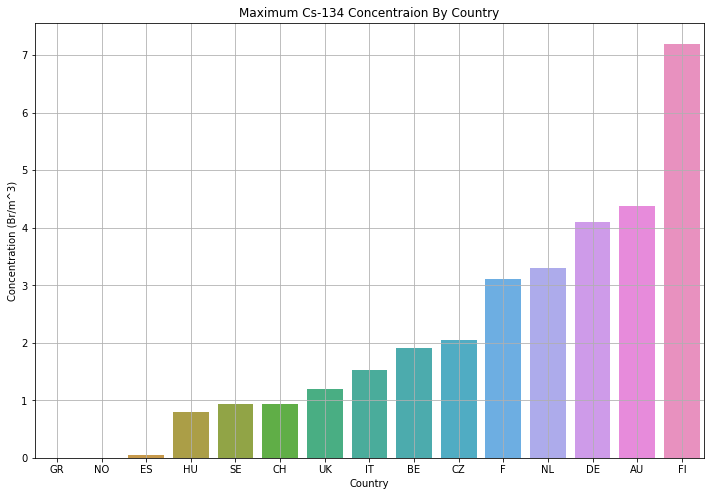

In [23]:
plt.figure(figsize=(12,8))
ax = sns.barplot(data=plt_data3, x="country_iso", y='Cs134_conc')

ax.set(xlabel='Country',
       ylabel='Concentration (Br/m^3)',
       title='Maximum Cs-134 Concentraion By Country')

# still have to do folllowing using matplotlib functions
plt.grid()
plt.show()

## Comparision Between Matplotlib and Seaborn

Based off the experience of creating the same plots in both matplotlib and seaborn, here are a few takeaways:

* Plotting the actual data on the plot seems to be easier in Seaborn, with arguments like `hue` enabling you to easily group data and show multiple lines, bars, etc on the same graph with automated legend creation. 
* However, when it comes to the nitty-gritty (i.e. adding gridlines, annotations, font changes) matplotlib is still required. It provides one with the ability to fine tune visualizations to fit the needs of the presenter. 
